# Problem Set 3

## Problem 1: Cross-Validation and Learning Curve (6 points)

In this exercise, we will perform linear regression on a single variable. The model assumed is
$$y = \beta_0 + \sum\limits_{i=1}^p \beta_i \sin ix\pi + \sum\limits_{i=1}^p \beta_{i+p} \cos ix\pi \, ,$$
with a single free parameter $p \in \mathbb{N}$. This model is conceptually very similar to a so-called (real-valued) discrete Fourier transform.

Below, you are provided with a class, `FourierRegression`, that performs this regression as a function of $p$ and follows the general `scikit-learn` `fit` and `predict` API. You also have a training set `X_train` and `y_train`. A test or validation set is not explicitly provided since we will be using hold-out validation in this exercise.

(a) Perform a $k$-fold cross-validation with $k=10$ for $p=1, 2,..., 100$. Plot the mean $R^2$ test score as a function of $p$. Which model among the $100$ tested performs best? (Hint: You can use `sklearn.model_selection.GridSearchCV`.)

(b) Plot the learning curves for $p=2$, $5$, $10$, $20$, and $50$. The learning curves indicates the mean training and test scores as a function of $n$, the number of data points used for training. Among the tested values of $p$, which model performs best when the training set size is:

* $n=10$,
* $n=100$, and
* $n=1000$?

(Hint: You can use `sklearn.model_selection.learning_curve`. Also, you probably want to limit the $y$-range in the plot to $R^2 \geq 0$ and make the $x$-axis logarithmic.)

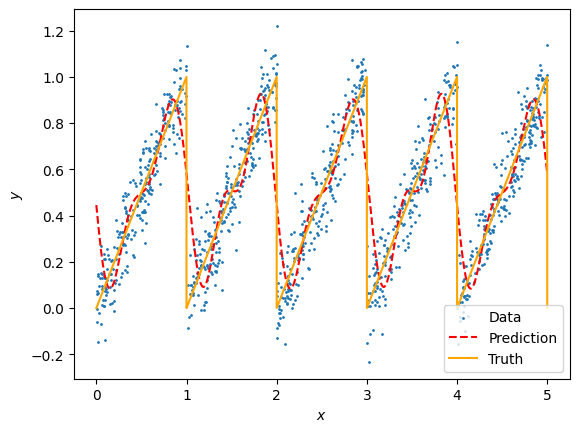

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

def f(X):
    return X[:, 0] % 1

class FourierRegression(BaseEstimator, RegressorMixin):

    # initiate regression model and specify p-value
    def __init__(self, p=1):
        self.p = p

    # create design matrix
    def design_matrix(self, X):
        return np.column_stack(
            [np.ones(len(X))] +
            [np.sin(X * np.pi * i) for i in range(1, self.p + 1)] +
            [np.cos(X * np.pi * i) for i in range(1, self.p + 1)])

    # fit beta values
    def fit(self, X, y):
        X = self.design_matrix(X)
        self.beta = np.linalg.lstsq(X, y)[0]
        return self

    # predict y-values
    def predict(self, X):
        X = self.design_matrix(X)
        return X @ self.beta

# create training data (psuedo-random)
np.random.seed(0)
X_train = np.random.uniform(0, 5, size=1250).reshape(-1, 1)
y_train = f(X_train) + np.random.normal(size=len(X_train)) * 0.1

# plot training data
plt.scatter(X_train[:, 0], y_train, label='Data', s = 1)

# beta values for p = 5
reg = FourierRegression(p=5).fit(X_train, y_train)

# generate values for design matrix
X = np.linspace(0, 5, 10000).reshape(-1, 1)

# predict and plot y-values
plt.plot(X[:, 0], reg.predict(X), color='red', ls='--', label='Prediction')
# overplot truth
plt.plot(X[:, 0], f(X), color='orange', ls='-', label='Truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(loc='best')



Test R2 Scores [n=10, n=100, n=1000]
P = 2: [0.34504209 0.5357639  0.55939119]
P = 5: [-19.55389371   0.65657259   0.70100994]
P = 10: [-0.37948783  0.72169597  0.7877453 ]
P = 20: [-1.29449721 -4.30884408  0.82254263]
P = 50: [-2.11177675e+00 -3.89813198e+22  8.44860655e-01]


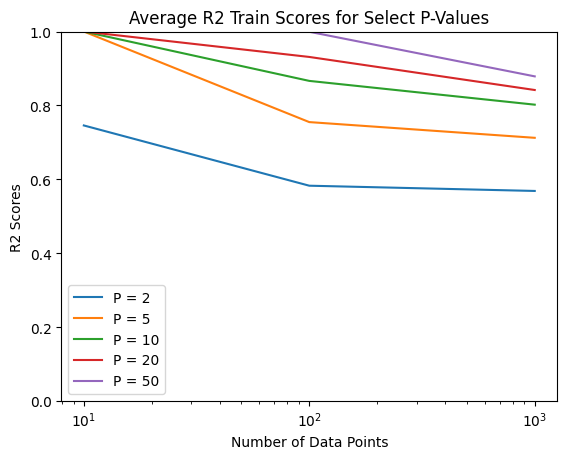

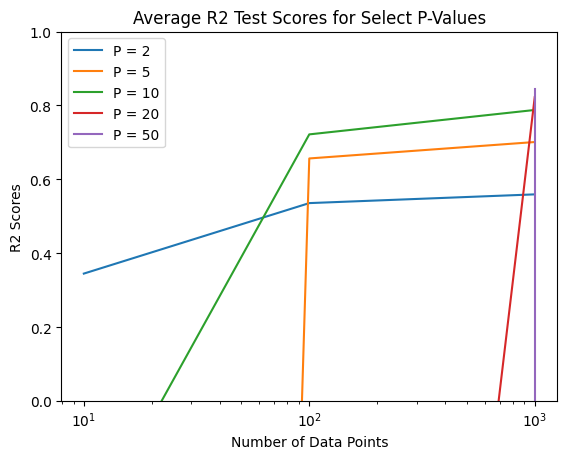

In [18]:
from sklearn.metrics import r2_score
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import model_selection
import matplotlib.pyplot as plt

def f(X):
    return X[:, 0] % 1

class FourierRegression(BaseEstimator, RegressorMixin):

    # initiate regression model and specify p-value
    def __init__(self, p=1):
        self.p = p

    # create design matrix
    def design_matrix(self, X):
        return np.column_stack(
            [np.ones(len(X))] +
            [np.sin(X * np.pi * i) for i in range(1, self.p + 1)] +
            [np.cos(X * np.pi * i) for i in range(1, self.p + 1)])

    # fit beta values
    def fit(self, X, y):
        X = self.design_matrix(X)
        self.beta = np.linalg.lstsq(X, y)[0]
        return self

    # predict y-values
    def predict(self, X):
        X = self.design_matrix(X)
        return X @ self.beta

# create training data (psuedo-random)
np.random.seed(0)
X_train = np.random.uniform(0, 5, size=1250).reshape(-1, 1)
y_train = f(X_train) + np.random.normal(size=len(X_train)) * 0.1
k_splits = 10

def a():
    # create model
    p_all = np.arange(1, 101)
    kf = model_selection.KFold(n_splits=k_splits)
    reg = model_selection.GridSearchCV(FourierRegression(), dict(p=p_all), cv = kf, scoring='r2', return_train_score=True).fit(X_train, y_train)
    cv_scores = reg.cv_results_['mean_test_score']
    train_scores = reg.cv_results_['mean_train_score']

    # plot
    plt.plot(p_all, cv_scores, label='CV score')
    plt.plot(p_all, train_scores, label='Train score')
    plt.xticks(np.arange(1, 101, 5))
    plt.xlabel("P-Value")
    plt.ylabel("R2 Scores")
    plt.title(f"Average R2 Scores for {k_splits}-fold Cross Validation based on P-Value")
    plt.legend()
    plt.show()

def b():
    # create model
    p_focus = [2, 5, 10, 20, 50]
    p_legend = ["P = 2", "P = 5", "P = 10", "P = 20", "P = 50"]
    n_list = [10, 100, 1000]
    all_train_scores = []
    all_test_scores = []

    for p in p_focus:
        # train scores = [n_ticks][n_cv_folds] scores on training sets
        # validation scores = [n_ticks][n_cv_folds] scores on test sets
        train_sizes, train_scores, validation_scores = model_selection.learning_curve(FourierRegression(p=p), X_train, y_train, train_sizes=n_list, cv=k_splits, scoring='r2')

        '''print(f"\n{p}")
        for row in range(len(train_scores)):
            print(f"{n_list[row]}: {train_scores[row]}\n")'''
        cv_train_score_list = np.mean(train_scores, axis = 1)
        all_train_scores.append(cv_train_score_list)
        cv_test_score_list = np.mean(validation_scores, axis = 1)
        all_test_scores.append(cv_test_score_list)


    '''print("Train R2 Scores [n=10, n=100, n=1000]")
    for p in range(len(all_train_scores)):
        print(f"{p_legend[p]}: {all_train_scores[p]}")'''

    print("\n\nTest R2 Scores [n=10, n=100, n=1000]")
    for p in range(len(all_test_scores)):
        print(f"{p_legend[p]}: {all_test_scores[p]}")

    # plot train scores
    plt.title(f"Average R2 Train Scores for Select P-Values")
    for p in range(len(all_train_scores)):
        plt.plot(n_list, all_train_scores[p], label=p_legend[p])
    plt.xscale('log')
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.ylabel("R2 Scores")
    plt.xlabel("Number of Data Points")
    plt.show()

    # plot test scores
    plt.title(f"Average R2 Test Scores for Select P-Values")
    for p in range(len(all_test_scores)):
        plt.plot(n_list, all_test_scores[p], label=p_legend[p])
    plt.xscale('log')
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.ylabel("R2 Scores")
    plt.xlabel("Number of Data Points")
    plt.show()
#a()
b()

A: Of the 100 p-values, I would choose somewhere around p=30 because that is about where the mean CV score peaks.
B: At n=10, p=2 performs the best. At n=100, p=10 performs the best. At n=1000, p=20 and p=50 seem similarly, but, based on the numerical data, p=50 just slightly outperforms p=20.